<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Predicting shots made per game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties Ridge, Lasso, and Elastic Net to try and predict how many shots Kobe Bryant made per game in his career.

The Kobe shots dataset has hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model considering the limited number of observations (games) we have available. Furthermore, many of the predictors have significant multicollinearity. 

**Warning:** Some of these calculations are computationally expensive and may take a while to execute.  It may be worth while to only use a portion of the data to perform these calculations, especially if you have experienced kernel issues in the past.

---

### 1. Load packages and data

In [1]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.preprocessing import Binarizer, Imputer, \
    OneHotEncoder, PolynomialFeatures, StandardScaler, \
    MinMaxScaler, RobustScaler

In [2]:
kobe = pd.read_csv('./datasets/kobe_superwide_games.csv')

---

### 2. Examine the data

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why is this data that regularization might be particularly useful for?

In [3]:
kobe.shape

(1558, 645)

In [4]:
kobe.head()

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5


In [5]:
kobe.describe()


,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
count,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,...,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000
mean,7.358793,0.500642,0.001284,0.001284,0.000642,0.000642,0.001284,0.001284,0.000642,0.000642,...,0.000064,0.006207,0.002047,0.000032,0.014149,0.000050,0.000433,0.031766,42.946727,780.486521
std,3.471180,0.500160,0.035817,0.035817,0.025335,0.025335,0.035817,0.035817,0.025335,0.025335,...,0.001791,0.022033,0.011133,0.001267,0.041313,0.001390,0.004902,0.049402,26.048206,449.923227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,391.250000
50%,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,780.500000
75%,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,63.000000,1169.750000
max,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.050000,0.250000,0.133333,0.050000,0.533333,0.041667,0.111111,0.352941,105.000000,1559.000000


In [6]:
list(kobe.columns)
# the columns describe the shots that were made and all the seasons he played for each column

['SHOTS_MADE',
 'AWAY_GAME',
 'SEASON_OPPONENT:atl:1996-97',
 'SEASON_OPPONENT:atl:1997-98',
 'SEASON_OPPONENT:atl:1999-00',
 'SEASON_OPPONENT:atl:2000-01',
 'SEASON_OPPONENT:atl:2001-02',
 'SEASON_OPPONENT:atl:2002-03',
 'SEASON_OPPONENT:atl:2003-04',
 'SEASON_OPPONENT:atl:2004-05',
 'SEASON_OPPONENT:atl:2005-06',
 'SEASON_OPPONENT:atl:2006-07',
 'SEASON_OPPONENT:atl:2007-08',
 'SEASON_OPPONENT:atl:2008-09',
 'SEASON_OPPONENT:atl:2009-10',
 'SEASON_OPPONENT:atl:2010-11',
 'SEASON_OPPONENT:atl:2011-12',
 'SEASON_OPPONENT:atl:2012-13',
 'SEASON_OPPONENT:atl:2013-14',
 'SEASON_OPPONENT:atl:2014-15',
 'SEASON_OPPONENT:atl:2015-16',
 'SEASON_OPPONENT:bkn:2012-13',
 'SEASON_OPPONENT:bkn:2015-16',
 'SEASON_OPPONENT:bos:1996-97',
 'SEASON_OPPONENT:bos:1997-98',
 'SEASON_OPPONENT:bos:1999-00',
 'SEASON_OPPONENT:bos:2001-02',
 'SEASON_OPPONENT:bos:2002-03',
 'SEASON_OPPONENT:bos:2003-04',
 'SEASON_OPPONENT:bos:2004-05',
 'SEASON_OPPONENT:bos:2005-06',
 'SEASON_OPPONENT:bos:2006-07',
 'SEASON_OP

---

### 3. Make predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:

X = kobe.iloc[:, 1:]
y = kobe['SHOTS_MADE']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1043, 644)
(515, 644)
(1043,)
(515,)


In [10]:
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)

In [11]:
X_train_ss[0:5]

array([[ 0.98194626,  0.        , -0.04383183, ...,  0.42292421,
         0.05563348, -0.33988601],
       [ 0.98194626,  0.        , -0.04383183, ..., -0.64931211,
        -1.58480445, -1.57267453],
       [ 0.98194626,  0.        , -0.04383183, ..., -0.64931211,
         0.66602899, -1.44162133],
       [-1.01838567,  0.        , -0.04383183, ...,  1.20273245,
        -1.24145698, -0.2243815 ],
       [ 0.98194626,  0.        , -0.04383183, ..., -0.64931211,
        -0.40216315, -0.17551421]])

---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [12]:
# Linear model

lr = LinearRegression()
model1 = lr.fit(X_train_ss, y_train)
train_score = model1.score(X_train_ss, y_train)
print('model score on training data: ', train_score)

model score on training data:  0.806197227683


In [13]:
# trying out on X_test
X_test_ss = ss.transform(X_test)

test_score = lr.score(X_test_ss, y_test)
print(test_score)
# the test data didn't too well with the training data model. The mean would have been a better option

-1.99263162579e+26


In [14]:
def top_coefs(columns, coefficients, n=25):
    columns = columns[1:]
    coefs = [(columns[i], coef) for i, coef in enumerate(coefficients)]
    return list(sorted(coefs, key=lambda x: abs(x[1]), reverse=True))[:n]

In [15]:
top_coefs(kobe.columns, model1.coef_)

[('SEASON:2007-08', 52888740351515.594),
 ('SEASON_OPPONENT:noh:2002-03', 44306826108116.461),
 ('SEASON:2014-15', 40254647151267.945),
 ('SEASON:2012-13', -39147635778033.531),
 ('SEASON_OPPONENT:bos:2004-05', -37225521971956.797),
 ('SEASON_OPPONENT:min:2009-10', 36817200910892.539),
 ('SEASON_OPPONENT:det:2011-12', -35581010937992.008),
 ('SEASON_OPPONENT:phi:2003-04', 31261355802763.82),
 ('SEASON:2015-16', 30429218346615.652),
 ('SEASON:2008-09', 30173132674913.668),
 ('SEASON:2006-07', -29319409482006.234),
 ('SEASON_OPPONENT:nyk:2006-07', 29073327213723.578),
 ('SEASON_OPPONENT:atl:1996-97', 28727266274664.406),
 ('SHOT_ZONE_BASIC:mid-range', 28668458950078.906),
 ('SEASON_OPPONENT:det:2015-16', -27302659812685.734),
 ('SEASON_OPPONENT:cle:2001-02', 27036545243393.383),
 ('SEASON:1996-97', -26831754997844.023),
 ('SEASON_OPPONENT:atl:2015-16', -26332876327354.914),
 ('SHOT_ZONE_RANGE:16-24_ft.', -25501091116266.34),
 ('SEASON_OPPONENT:phx:2008-09', -24361023780316.824),
 ('SEASO

In [16]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [17]:
lm = LinearRegression()
cv_train = cross_val_score(lr, X_train_ss, y_train, cv=10)
cv_test = cross_val_score(lm, X_test_ss, y_test, cv=10)
print(cv_train)
print(cv_test)
print(cv_train.mean())
print(cv_test.mean())
# this model performs poorly with a large negative value

[ -3.91274786e+28  -4.84018766e+28  -5.07210580e+28  -5.95769953e+28
  -4.66858413e+28  -7.29105419e+28  -7.70777734e+28  -3.85624232e+28
  -4.63429631e+28  -5.93766020e+28]
[ -3.92010992e+27  -1.33157089e+28  -2.72884370e+28  -1.72840648e+28
  -1.54811006e+28  -3.38110833e+28  -1.26397674e+28  -5.90272014e+27
  -3.03706611e+28  -4.33774549e+27]
-5.38783553242e+28
-1.64351398587e+28


---

### 5. Find an optimal value for Ridge regression alpha using `RidgeCV`.

[Go to the documentation and read how RidgeCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)

> *Hint: once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Ridge performs best searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit!


In [18]:
from sklearn.linear_model import RidgeCV

In [25]:
alpha = np.logspace(0,10,200)

ridge = RidgeCV(alphas=alpha, cv=10)
ridge_score = ridge.fit(X_train_ss, y_train)
print(ridge_score)
ridge_alpha = ridge_score.alpha_
# this will determine our best alpha value for the ridge regression

RidgeCV(alphas=array([  1.00000e+00,   1.12267e+00, ...,   8.90735e+09,   1.00000e+10]),
    cv=10, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)


In [ ]:
print(ridge_alpha) # optimal ridge alpha

---

### 6. Cross-validate the Ridge regression $R^2$ with the optimal alpha.

Is it better than the Linear regression? If so, why might this be?

In [27]:
# A:
rdge = Ridge(alpha=ridge_alpha)
rdge.fit(X_train_ss, y_train)
rdge_train = rdge.score(X_train_ss, y_train)
rdge_test = rdge.score(X_test_ss, y_test)
print('model score for training dataset is ', rdge_train)
print('model score for test dataset is ', rdge_test)

# yes the ridge regression is way better than the linear regression model because it fits well with the training and test data
# unlike the linear regression model with the training dataset because it was overfitting.

model score for training dataset is  0.774486576177
model score for test dataset is  0.631309265468


In [28]:
def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list
        coefs.append(ridge_reg.coef_)
        
    return coefs

In [29]:
ridge_coefs(X_test_ss, y_test, alpha)

[array([ -4.48612275e-01,  -5.45075650e-01,   4.94578810e-29,
         -9.89157619e-29,  -2.47289405e-29,   4.94578810e-29,
         -7.81164431e-02,  -2.47289405e-29,  -9.89157619e-29,
          4.94578810e-29,   1.00062649e-01,   4.94578810e-29,
         -2.10685163e-01,   1.43957631e-03,   4.94578810e-29,
         -2.47289405e-29,  -8.44942783e-02,  -4.94578810e-29,
         -2.47289405e-29,  -5.29925509e-01,   1.67312080e-01,
         -2.47289405e-29,  -2.47289405e-29,  -4.84688157e-02,
          4.94578810e-29,   4.94578810e-29,   4.94578810e-29,
          3.90434723e-02,  -4.27257421e-01,   4.94578810e-29,
          4.94578810e-29,  -8.03145760e-02,  -7.32980435e-02,
          3.87913425e-02,   4.94578810e-29,  -1.55735070e-01,
         -1.06433961e-02,  -2.47289405e-29,  -1.25909662e-01,
          3.69755987e-02,  -9.59742551e-02,  -9.89157619e-29,
          4.94578810e-29,  -1.18550089e-01,   4.94578810e-29,
         -2.47289405e-29,   1.69956852e-01,  -4.64387327e-02,
        

---

### 7. Find an optimal value for Lasso regression alpha using `LassoCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) It is very similar to `RidgeCV`.

> *Hint: again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that Lasso, unlike Ridge, performs best searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide itself what alphas to use by instead setting the keyword argument `n_alphas=` to however many alphas you want it to search over. It is recommended to let sklearn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if its working set `verbose =1`._

In [31]:
# A:
from sklearn.linear_model import LassoCV
ls_cv = LassoCV(n_alphas=100, cv=10, verbose=1)
ls_score = ls_cv.fit(X_train_ss, y_train)
lasso_alpha = ls_score.alpha_

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [32]:
print(lasso_alpha)

0.104458639265


---

### 8. Cross-validate the Lasso $R^2$ with the optimal alpha.

Is it better than the Linear regression? Is it better than Ridge? What do the differences in results imply about the issues with the dataset?

In [33]:
# A:
lasso = Lasso(lasso_alpha)
lasso.fit(X_train_ss, y_train)
lasso_train = lasso.score(X_train_ss, y_train)
lasso_test = lasso.score(X_test_ss, y_test)
print('lasso model score for training is ', lasso_train)
print('lasso model score for test is ', lasso_test)
# lasso regression is the best because there is a less of a different on the model scores between training and test data compared to the ridge
# the lasso actually makes the coefficients 0s rather minimizing them

lasso model score for training is  0.687288314134
lasso model score for test is  0.664368984033


---

### 9. Look at the coefficients for variables in the Lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original dataset are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** if you only fit the Lasso within `cross_val_score`, you will have to refit it outside of that
function to pull out the coefficients.

In [46]:
kobe.index.values

array([   0,    1,    2, ..., 1555, 1556, 1557], dtype=int64)

In [53]:
lasso_coeff_pd = pd.DataFrame({'columns':X_train.columns, 'coefs':lasso.coef_, 'abs_value':np.abs(lasso.coef_)})

In [70]:
lasso_coeff_pd_new = lasso_coeff_pd.sort_values(by='abs_value', ascending=False)

In [73]:
lasso_coeff_pd_new.head()

,abs_value,coefs,columns
574,0.683328,0.683328,SHOT_TYPE:2pt_field_goal
582,0.606120,0.606120,SECONDS_REMAINING
584,0.430164,0.430164,PERIOD
477,0.000000,0.000000,SEASON_OPPONENT:tor:2004-05
430,0.000000,0.000000,SEASON_OPPONENT:sac:2006-07


In [75]:
len(lasso_coeff_pd_new)/len(lasso_coeff_pd)

1.0

---

### 10. Find an optimal value for Elastic Net regression alpha using `ElasticNetCV`.

[Go to the documentation and read how LassoCV works.](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note here that you will be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: strength of regularization
- `l1_ratio`: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)
    
Do not include 0 in the search for `l1_ratio`: it will not allow it and break!

You can use `n_alphas` for the alpha parameters instead of setting your own values: highly recommended!

Also - be careful setting too many l1_ratios over cross-validation folds in your search. It can take a very long time if you choose too many combinations and for the most part there are diminishing returns in this data.

In [80]:
# A:
en = ElasticNetCV(l1_ratio=0.1, n_alphas=100)
en_model = en.fit(X_train_ss, y_train)

print(en_model.alpha_)
en.score(X_train_ss, y_train)

0.597750739072


0.72081530226380819

In [82]:
en.score(X_test_ss, y_test)

0.65191859506670569

In [81]:
en_l1_ratio = en_model.l1_ratio_
en_l1_ratio

0.10000000000000001

---

### 11. Cross-validate the ElasticNet $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the Ridge and Lasso regularized regressions?

In [83]:
# A:
enet = ElasticNet(alpha=en_model.alpha_, l1_ratio=en_model.l1_ratio_)

In [84]:
enet.fit(X_train_ss, y_train)
en_training = enet.score(X_train_ss, y_train)
en_test = enet.score(X_test_ss, y_test)
print('elastic net model score for training is ', en_training)
print('elastic net model score for test is ', en_test)


elastic net model score for training is  0.720815302264
elastic net model score for test is  0.651918595067


---

### 12. [Bonus] Compare the residuals for the Ridge and Lasso visually.


In [88]:
lasso_fit = lasso.fit(X_train_ss, y_train)
lasso_predict = lasso.predict(X_train_ss)

ridge_fit = rdge.fit(X_train_ss, y_train)
ridge_predict = rdge.predict(X_train_ss)

lasso_residual = y_train - lasso_predict
ridge_residual = y_train - ridge_predict

In [91]:
print(lasso_residual[0:5])
print(ridge_residual[0:5])

630   -0.219838
75    -3.220338
134   -3.383724
682    0.913772
704   -1.619030
Name: SHOTS_MADE, dtype: float64
630    0.105332
75    -1.130845
134   -0.647450
682    0.411821
704   -1.401794
Name: SHOTS_MADE, dtype: float64


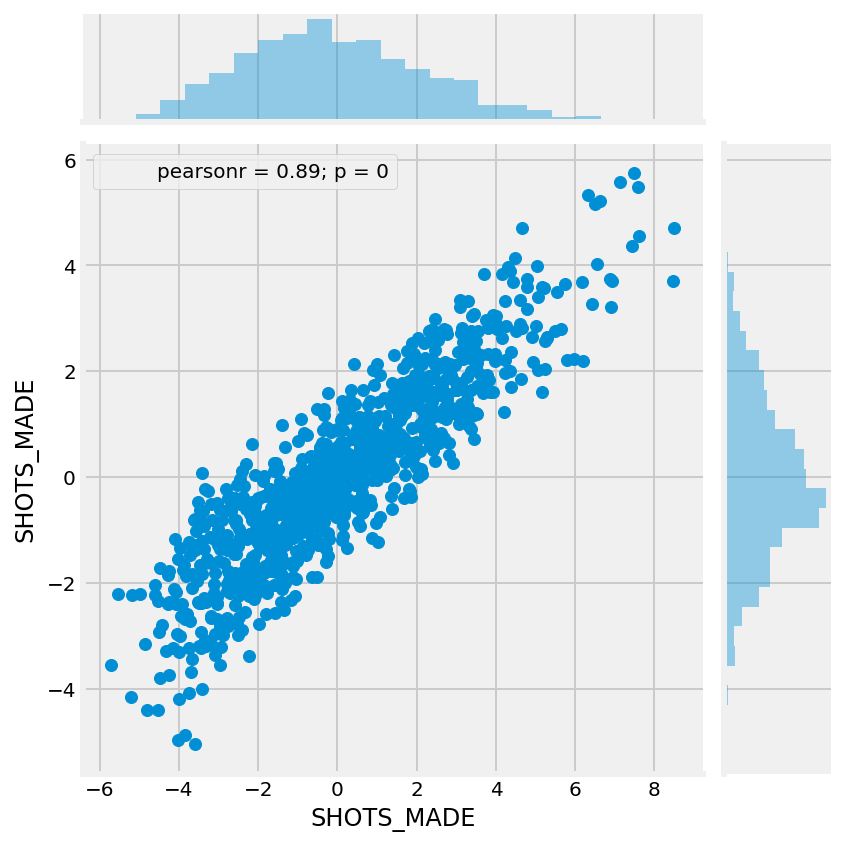

In [89]:
sns.jointplot(lasso_residual, ridge_residual)